In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amsfonts}"
%config InlineBackend.figure_format = 'retina'

<div class="alert alert-block alert-warning"> A working latex installation is needed to create plot titles. </div>

### A brief history
The idea of the following plottings come from the wonderful book [Computational Discovery on Jupyter](https://computational-discovery-on-jupyter.github.io/Computational-Discovery-on-Jupyter/index.html) and the gallery of this [web site](http://www.bohemianmatrices.com).

In [2]:
class Eigenfish:
    """
    A class for building an eigenfish plot.
    Parameters:
        matrix: a two-dimensional square ndarray
        indices_of_ts: a set of elements of matrix which are replace by parameters t_1, t_2, ..., t_n
                       for example (array([0, 5]), array([6, 3])) means that elements (0,6) and (5,3) are replaced
                       by t_1 and t_2
        
    """
    def __init__(self, matrix, indices_of_ts):
        self.matrix = matrix
        self.indices_of_ts = indices_of_ts #indices of parameters
        self.mdim = matrix.shape[0] #dimension of the matrix
        self.n_t = len(self.indices_of_ts[0])
        self.is_matrix_of_phases = np.all(np.abs(self.matrix)==1.0)
        
    def eigvals_random_ts_rect(self, n_ts, r):
        """
        This method calculate eigenvalues of the matrix, sampling t_1, t_2, ..., t_n parameters
        from an uniform probability distribution with support [-r, r] x [-r, r] x ... x [-r, r] 
        Parameters:
            n_ts: the number of sampled tuple (t_1, t_2, ..., t_n)
            r: defining the support range of the uniform probability distribution
        Returns:
            the ndarray of eigenvalues. Its number of elements is equal to n_ts * self.mdim
        """
        eigenvalues = np.zeros(n_ts*self.mdim, dtype=np.complex64)
        for i in range(n_ts):
            ts = tuple([np.random.uniform(-r,r) for _ in range(self.n_t)])
            self.matrix[self.indices_of_ts]=ts
            eigenvalues[i*self.mdim:(i+1)*self.mdim] = np.linalg.eigvals(self.matrix)
        return eigenvalues 
    
    def eigvals_normal_ts_rect(self, n_ts, s):
        """
        This method calculate eigenvalues of the matrix, sampling t_1, t_2, ..., t_n parameters
        from a multivariate normal probability distribution with standard deviation equal to s
        Parameters:
            n_ts: the number of sampled tuple (t_1, t_2, ..., t_n)
            s: standard deviation of th normal probability distribution
        Returns:
            the ndarray of eigenvalues. Its number of elements is equal to n_ts * self.mdim
        """
        eigenvalues = np.zeros(n_ts*self.mdim, dtype=np.complex64)
        for i in range(n_ts):
            ts = tuple([np.random.normal(0,s) for _ in range(self.n_t)])
            self.matrix[self.indices_of_ts]=ts
            eigenvalues[i*self.mdim:(i+1)*self.mdim] = np.linalg.eigvals(self.matrix)
        return eigenvalues 
    
    def eigvals_random_ts_torus(self, n_ts, radius=1.0):
        """
        This method calculate eigenvalues of the matrix, sampling t_1, t_2, ..., t_n parameters
        from an uniform probability distribution on a torus
        Parameters:
            n_ts: the number of sampled tuple (t_1, t_2, ..., t_n)
            radius: the value of tours radius, it is the same for each dimension
        Returns:
            the ndarray of eigenvalues. Its number of elements is equal to n_ts * self.mdim
        """
        eigenvalues = np.zeros(n_ts*self.mdim, dtype=np.complex64)
        for i in range(n_ts):
            ts = tuple([radius*np.exp(1.j*np.random.uniform(0., 2*np.pi)) for _ in range(self.n_t)])
            self.matrix[self.indices_of_ts]=ts
            eigenvalues[i*self.mdim:(i+1)*self.mdim] = np.linalg.eigvals(self.matrix)
        return eigenvalues
    
    def gershgorin_circles(self):
        """
        This methods calculate Gershgorin circle in the case of a matrix in which the absolute value of
        each element is equal to one.
        This method has to be improved. TODO.
        Please see https://en.wikipedia.org/wiki/Gershgorin_circle_theorem.
        Returns:
            a tuple containing 3 ndarray: x coordinate of circles centers, y coordinate of circles centers,
                                          radius of circles.
        """
        if self.is_matrix_of_phases:
            diag_elms = np.diag(self.matrix)
            radiuses = (mdim-1)*np.ones(mdim)
            return np.real(diag_elms), np.imag(diag_elms), radiuses
        else:
            return None

    def latex_matrix(self, max_real="1"):
        
        def clean(val):
            real, imag = np.real(val), np.imag(val)
            if imag != 0:
                return "i" if imag > 0 else "-i"
            real = str(real).replace(".0", "")
            return real if real in ["0", "0.5", max_real] else "tT"
        
        template = r" \\ ".join([" & ".join(["{}"] * self.mdim)] * self.mdim)
        filled = template.format(*map(clean, self.matrix.flatten()))
        final = filled.replace("T", "{}").format(*range(1, self.n_t+1))
        return r"\begin{pmatrix} " + final + r" \end{pmatrix}"

    def create_simple_latex_title_rect(self, rmin, rmax):
        title = self.latex_matrix()
        return f"$ {title} $"

    def create_latex_title_rect(self, rmin, rmax):
        title = (r"\lambda \in \mathbb{C} | \det(A-\lambda I)=0, \quad A="
            + self.latex_matrix() 
            + r", \quad "
            + ",".join([f"t{n+1}" for n in range(self.n_t)])
            + f" \in ({rmin}, {rmax}) ")
        return f"$ {title} $"
            
    def create_latex_title_torus(self):
        title = (r"\lambda \in \mathbb{C} | \det(A-\lambda I)=0, \quad A="
            + self.latex_matrix(max_real="0.2") 
            + r", \quad "
            + ",".join([f"t{n+1}" for n in range(self.n_t)])
            + r" \in S^{1} \times S^{1}")
        return f"$ {title} $"


### Plot for random matrices

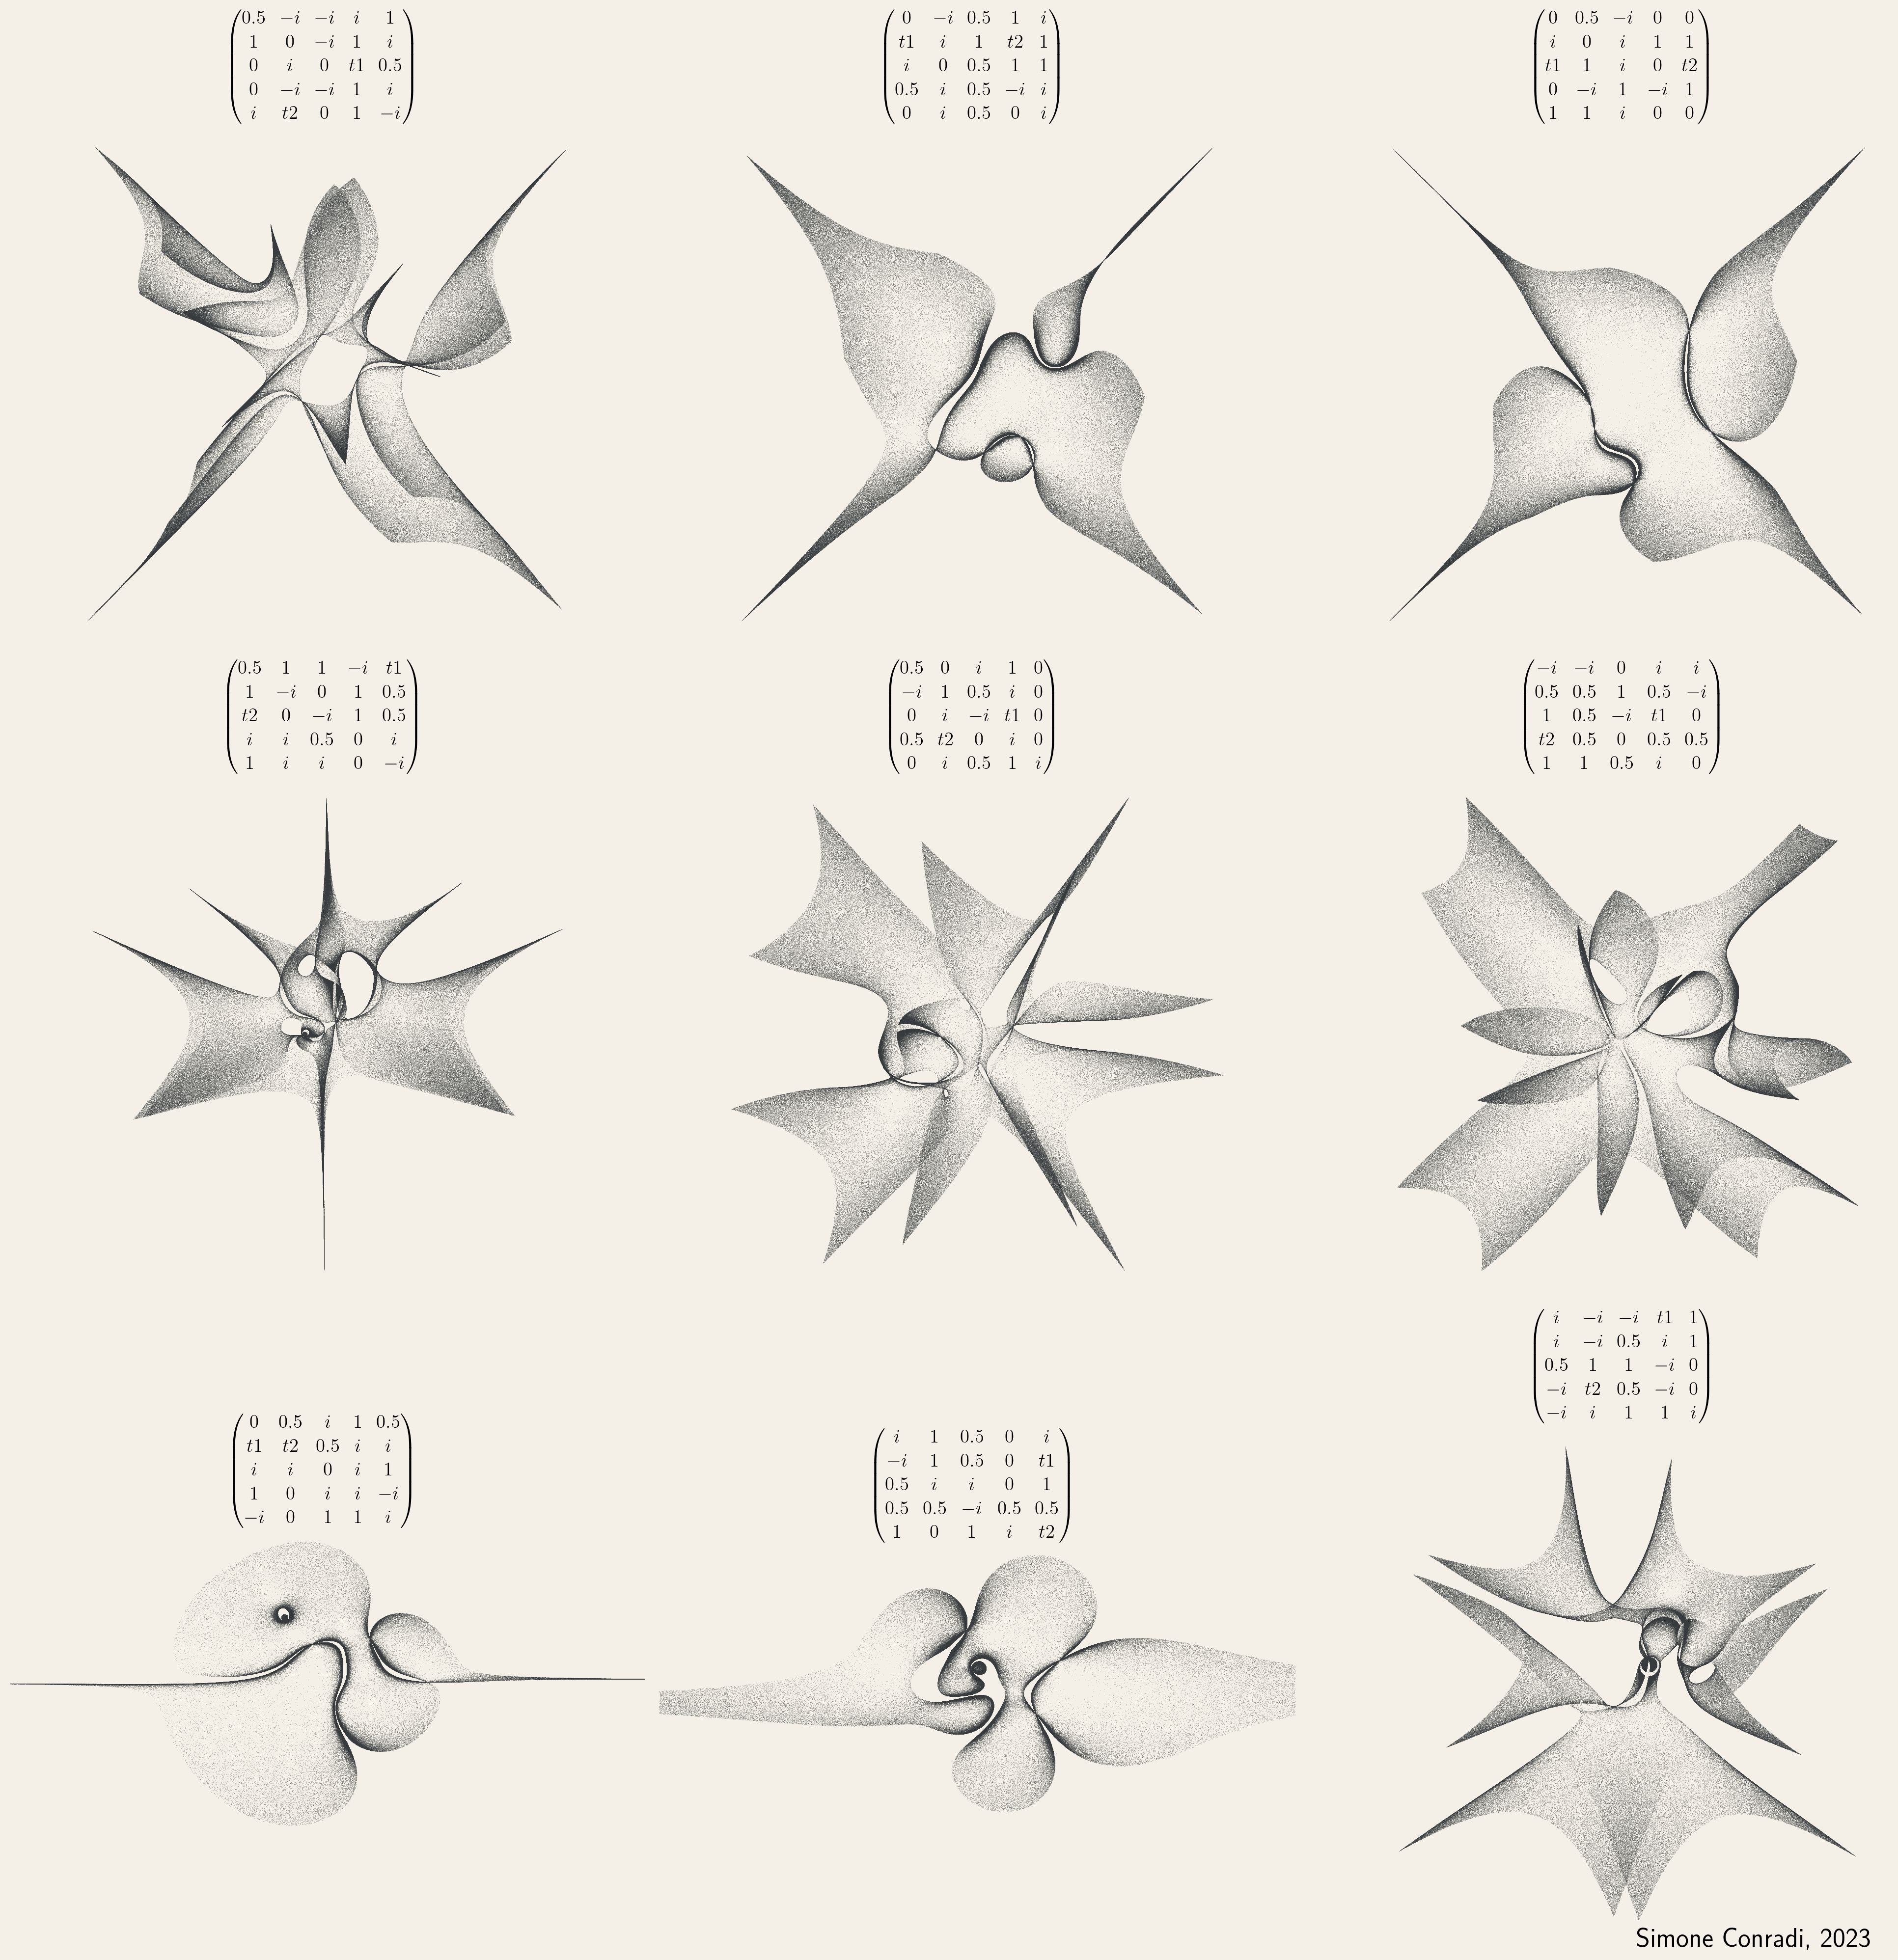

In [9]:
mdim = 5
population = np.array([0.,-1.j,1.j,1.,0.5])
r = 20
n_matrix = 100000
list_of_figure = []

fig, axs = plt.subplots(3, 3, figsize=(20,20))
fig.set_facecolor("#f4f0e8")
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

for ax in axs.reshape(-1):
    for spine in ['top', 'right','left','bottom']:
        ax.spines[spine].set_visible(False)
    matrix = np.random.choice(population, (mdim,mdim))+0.j
    var_indices = np.unravel_index(np.random.choice(np.arange(0, mdim**2), 2, replace=False), (mdim,mdim))
    eigenfish = Eigenfish(matrix, var_indices)
    list_of_figure.append(eigenfish)
    eigenvalues = eigenfish.eigvals_random_ts_rect(n_matrix, r)
    ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), c="#383b3e", s=0.03, linewidths= 0.0001, alpha=1.)
    #ax.set_title(eigenfish.create_latex_title_rect(-r,r), fontsize=12)
    ax.set_title(eigenfish.create_simple_latex_title_rect(-r,r), fontsize=14)
    ax.set_aspect('equal', 'box')
    if np.max(np.real(eigenvalues)>10):
        ax.set_xlim([-8,8])
    #ax.set_ylim([-7,7])
    ax.set_axis_off()
plt.tight_layout()
plt.annotate("Simone Conradi, 2023", (1200.,10.), xycoords="figure points", fontsize=20)
plt.show()    

### Zoom on one

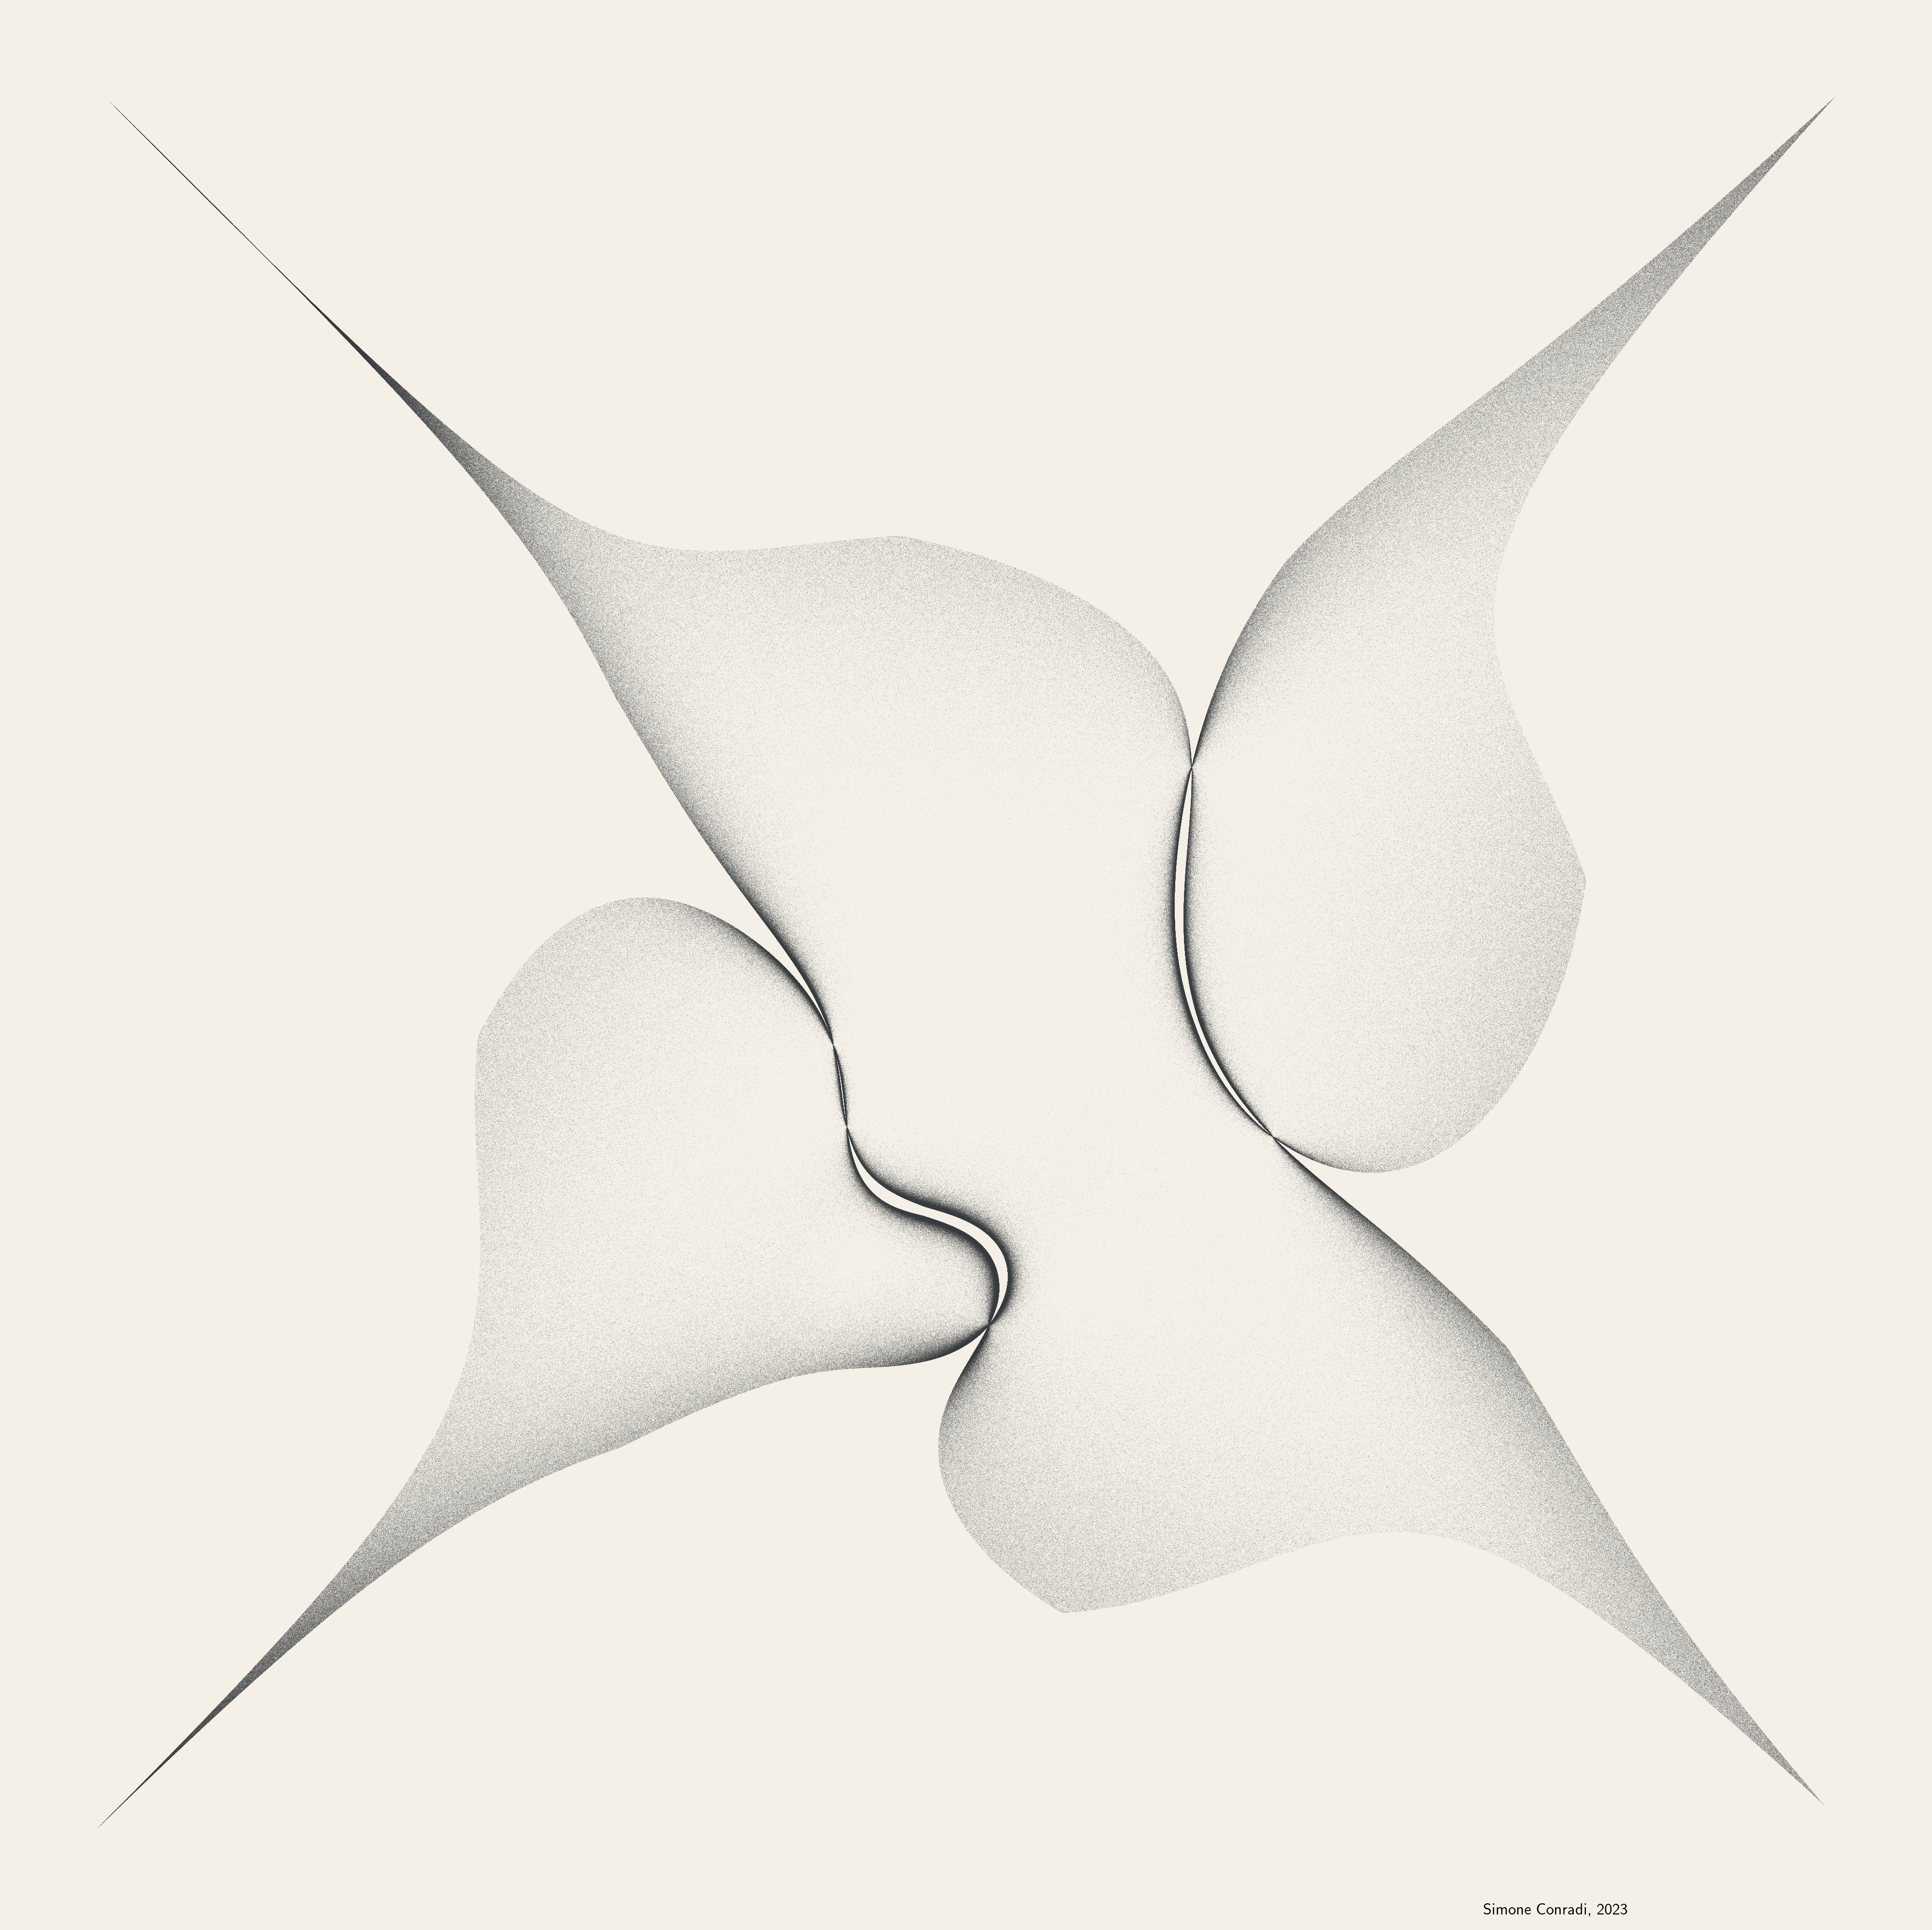

In [10]:
n_matrix = 500000
r = 20

chosen=2
eigenfish = list_of_figure[chosen]

fig, ax = plt.subplots(figsize=(20,20))
fig.set_facecolor("#f4f0e8")
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
for spine in ['top', 'right','left','bottom']:
    ax.spines[spine].set_visible(False)

eigenvalues = eigenfish.eigvals_random_ts_rect(n_matrix, r)
ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), c="#383b3e", s=0.02, linewidths= 0.0001, alpha=1.)

#ax.set_title(eigenfish.create_latex_title_rect(-r, r), fontsize=12)
ax.set_aspect('equal', 'box')
#ax.set_xlim([-8,8])
#ax.set_ylim([-8,8])
ax.set_axis_off()
plt.tight_layout()
plt.annotate("Simone Conradi, 2023", (1100.,12.), xycoords="figure points", fontsize=12)
plt.show()  

### Torus case

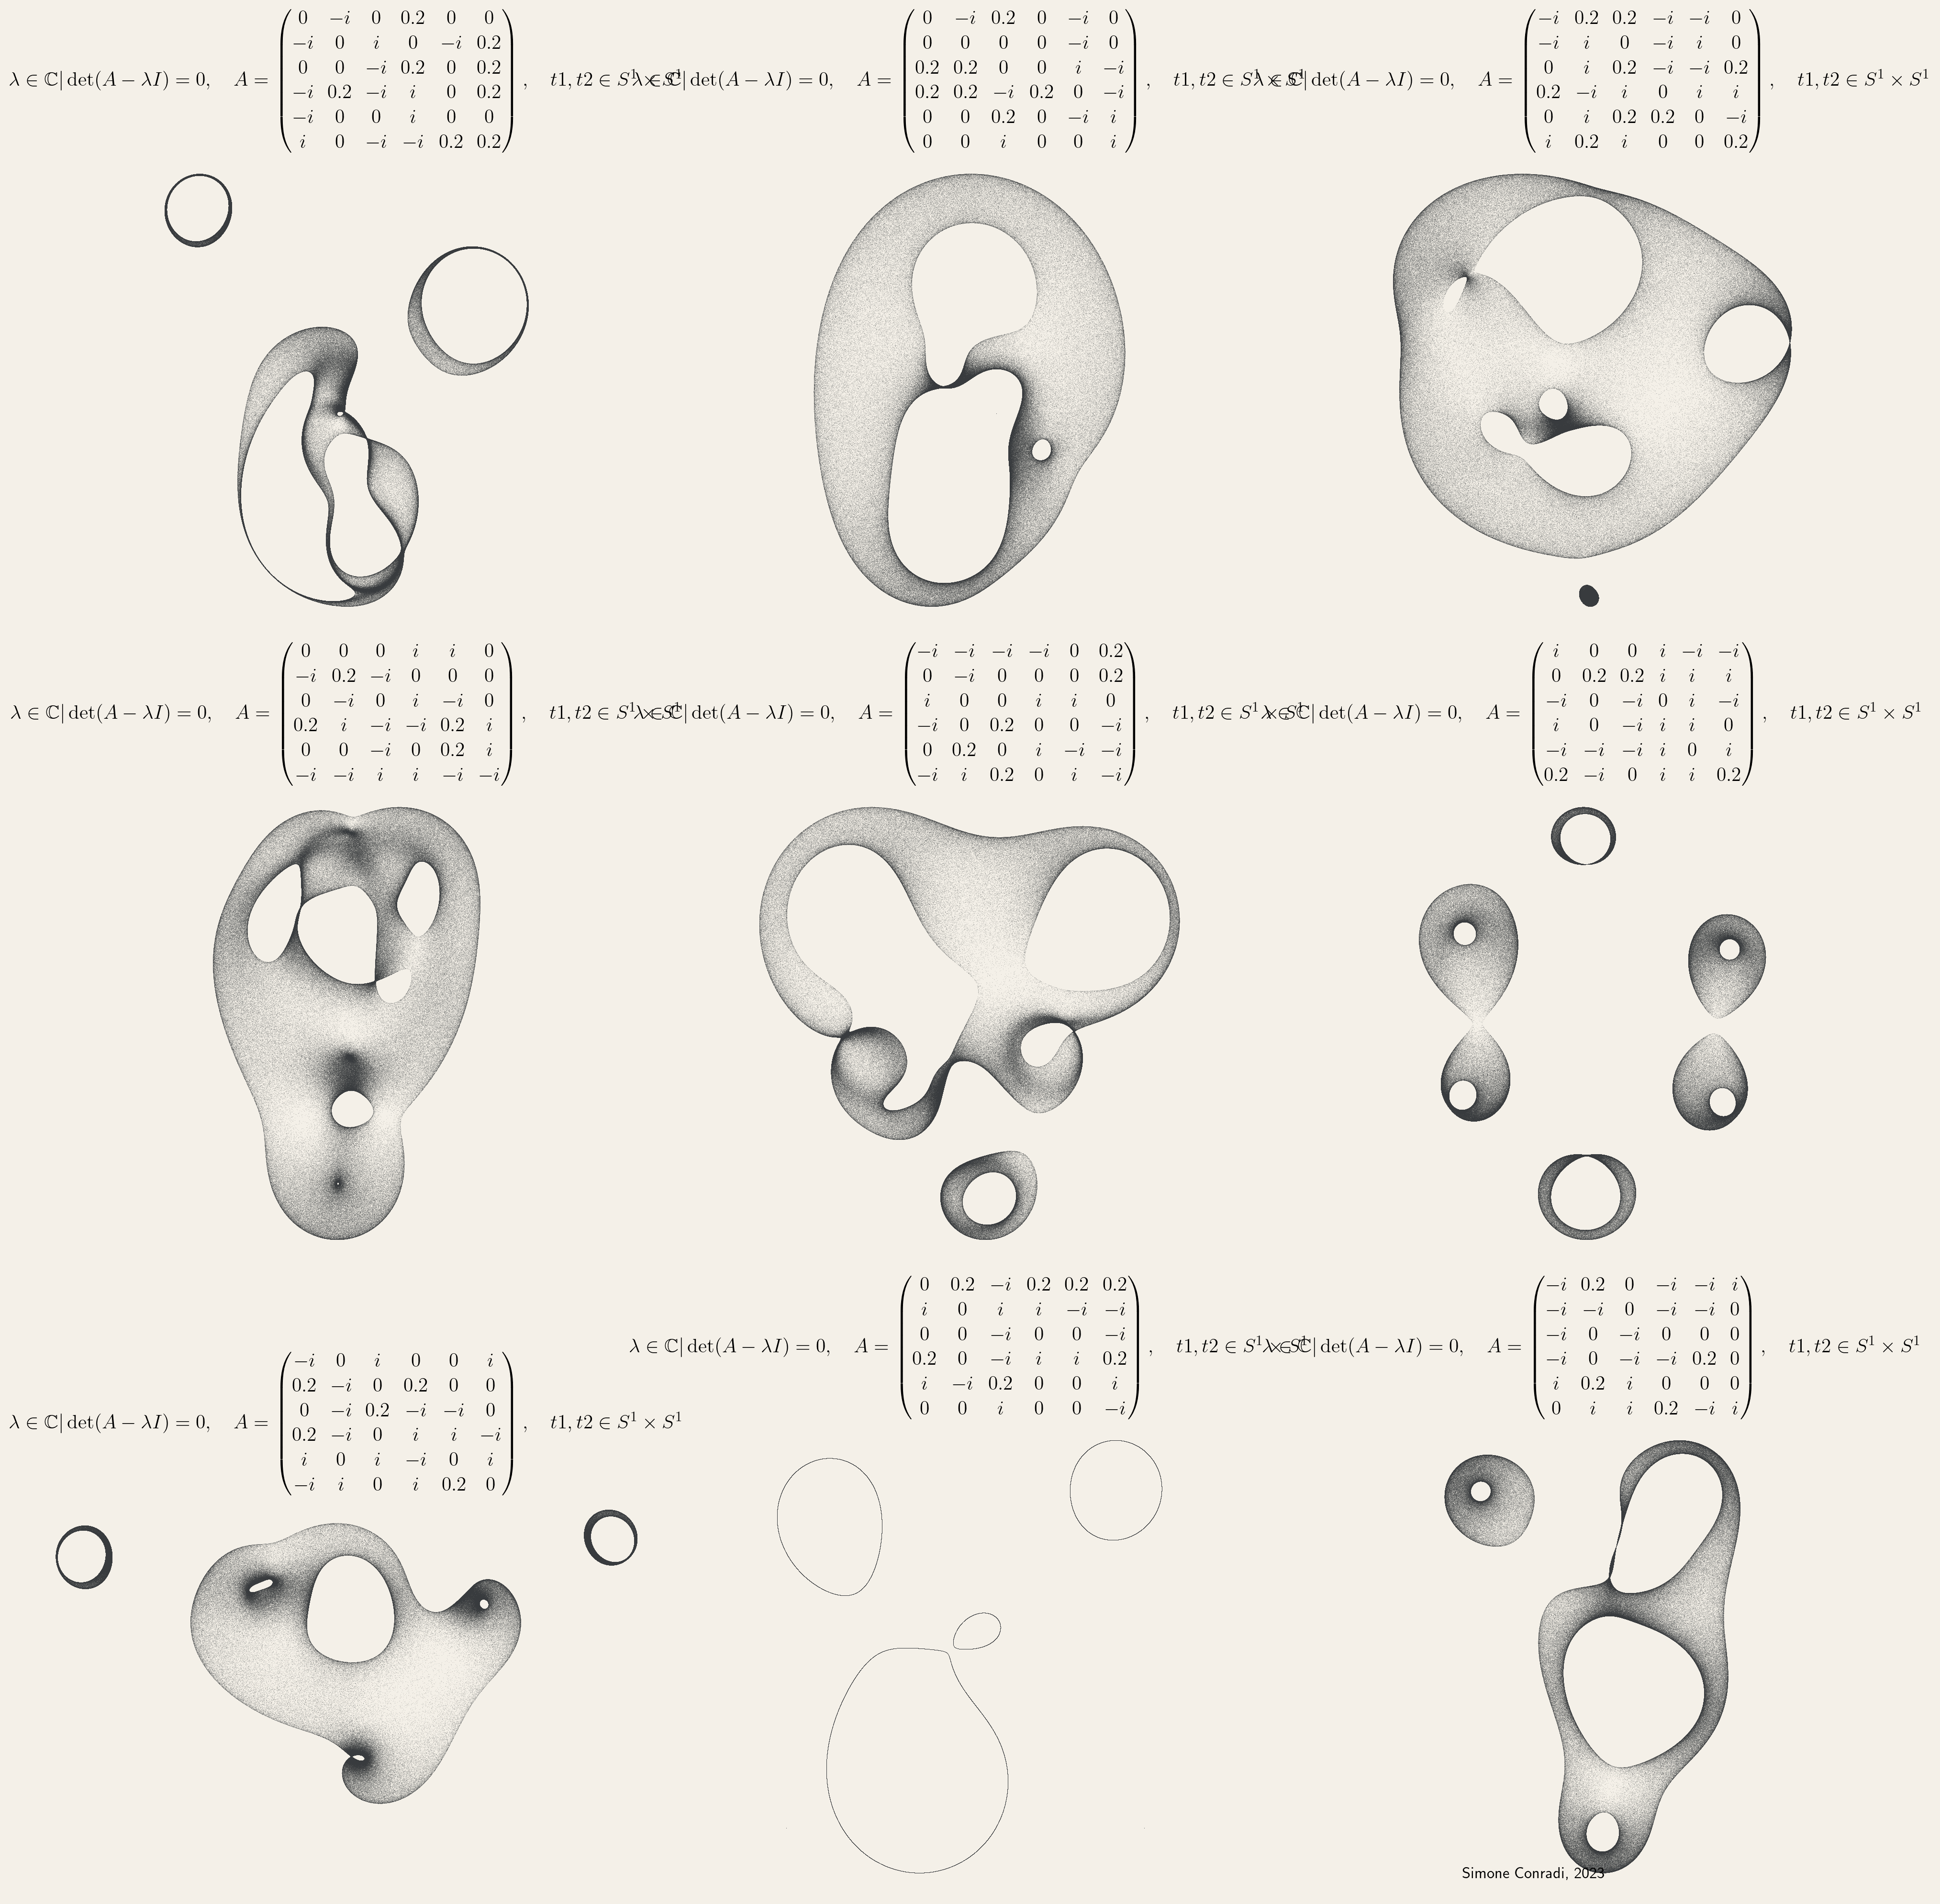

In [5]:
mdim = 6
population = np.array([0.,0.,-1.j,1.j,0.2])
r = 20
n_matrix = 100000
list_of_figure = []

fig, axs = plt.subplots(3, 3, figsize=(20,20))
fig.set_facecolor("#f4f0e8")
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

for ax in axs.reshape(-1):
    for spine in ['top', 'right','left','bottom']:
        ax.spines[spine].set_visible(False)
    matrix = np.random.choice(population, (mdim,mdim))+0.j
    var_indices = np.unravel_index(np.random.choice(np.arange(0, mdim**2), 2, replace=False), (mdim,mdim))
    eigenfish = Eigenfish(matrix, var_indices)
    list_of_figure.append(eigenfish)
    eigenvalues = eigenfish.eigvals_random_ts_torus(n_matrix)
    ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), c="#383b3e", s=0.02, linewidths= 0.0001, alpha=1.)
    ax.set_title(eigenfish.create_latex_title_torus(), fontsize=15)
    ax.set_aspect('equal', 'box')
    #ax.set_xlim([-8,8])
    #ax.set_ylim([-8,8])
    ax.set_axis_off()
plt.tight_layout()
plt.annotate("Simone Conradi, 2023", (1100.,20.), xycoords="figure points", fontsize=12)
plt.show()    

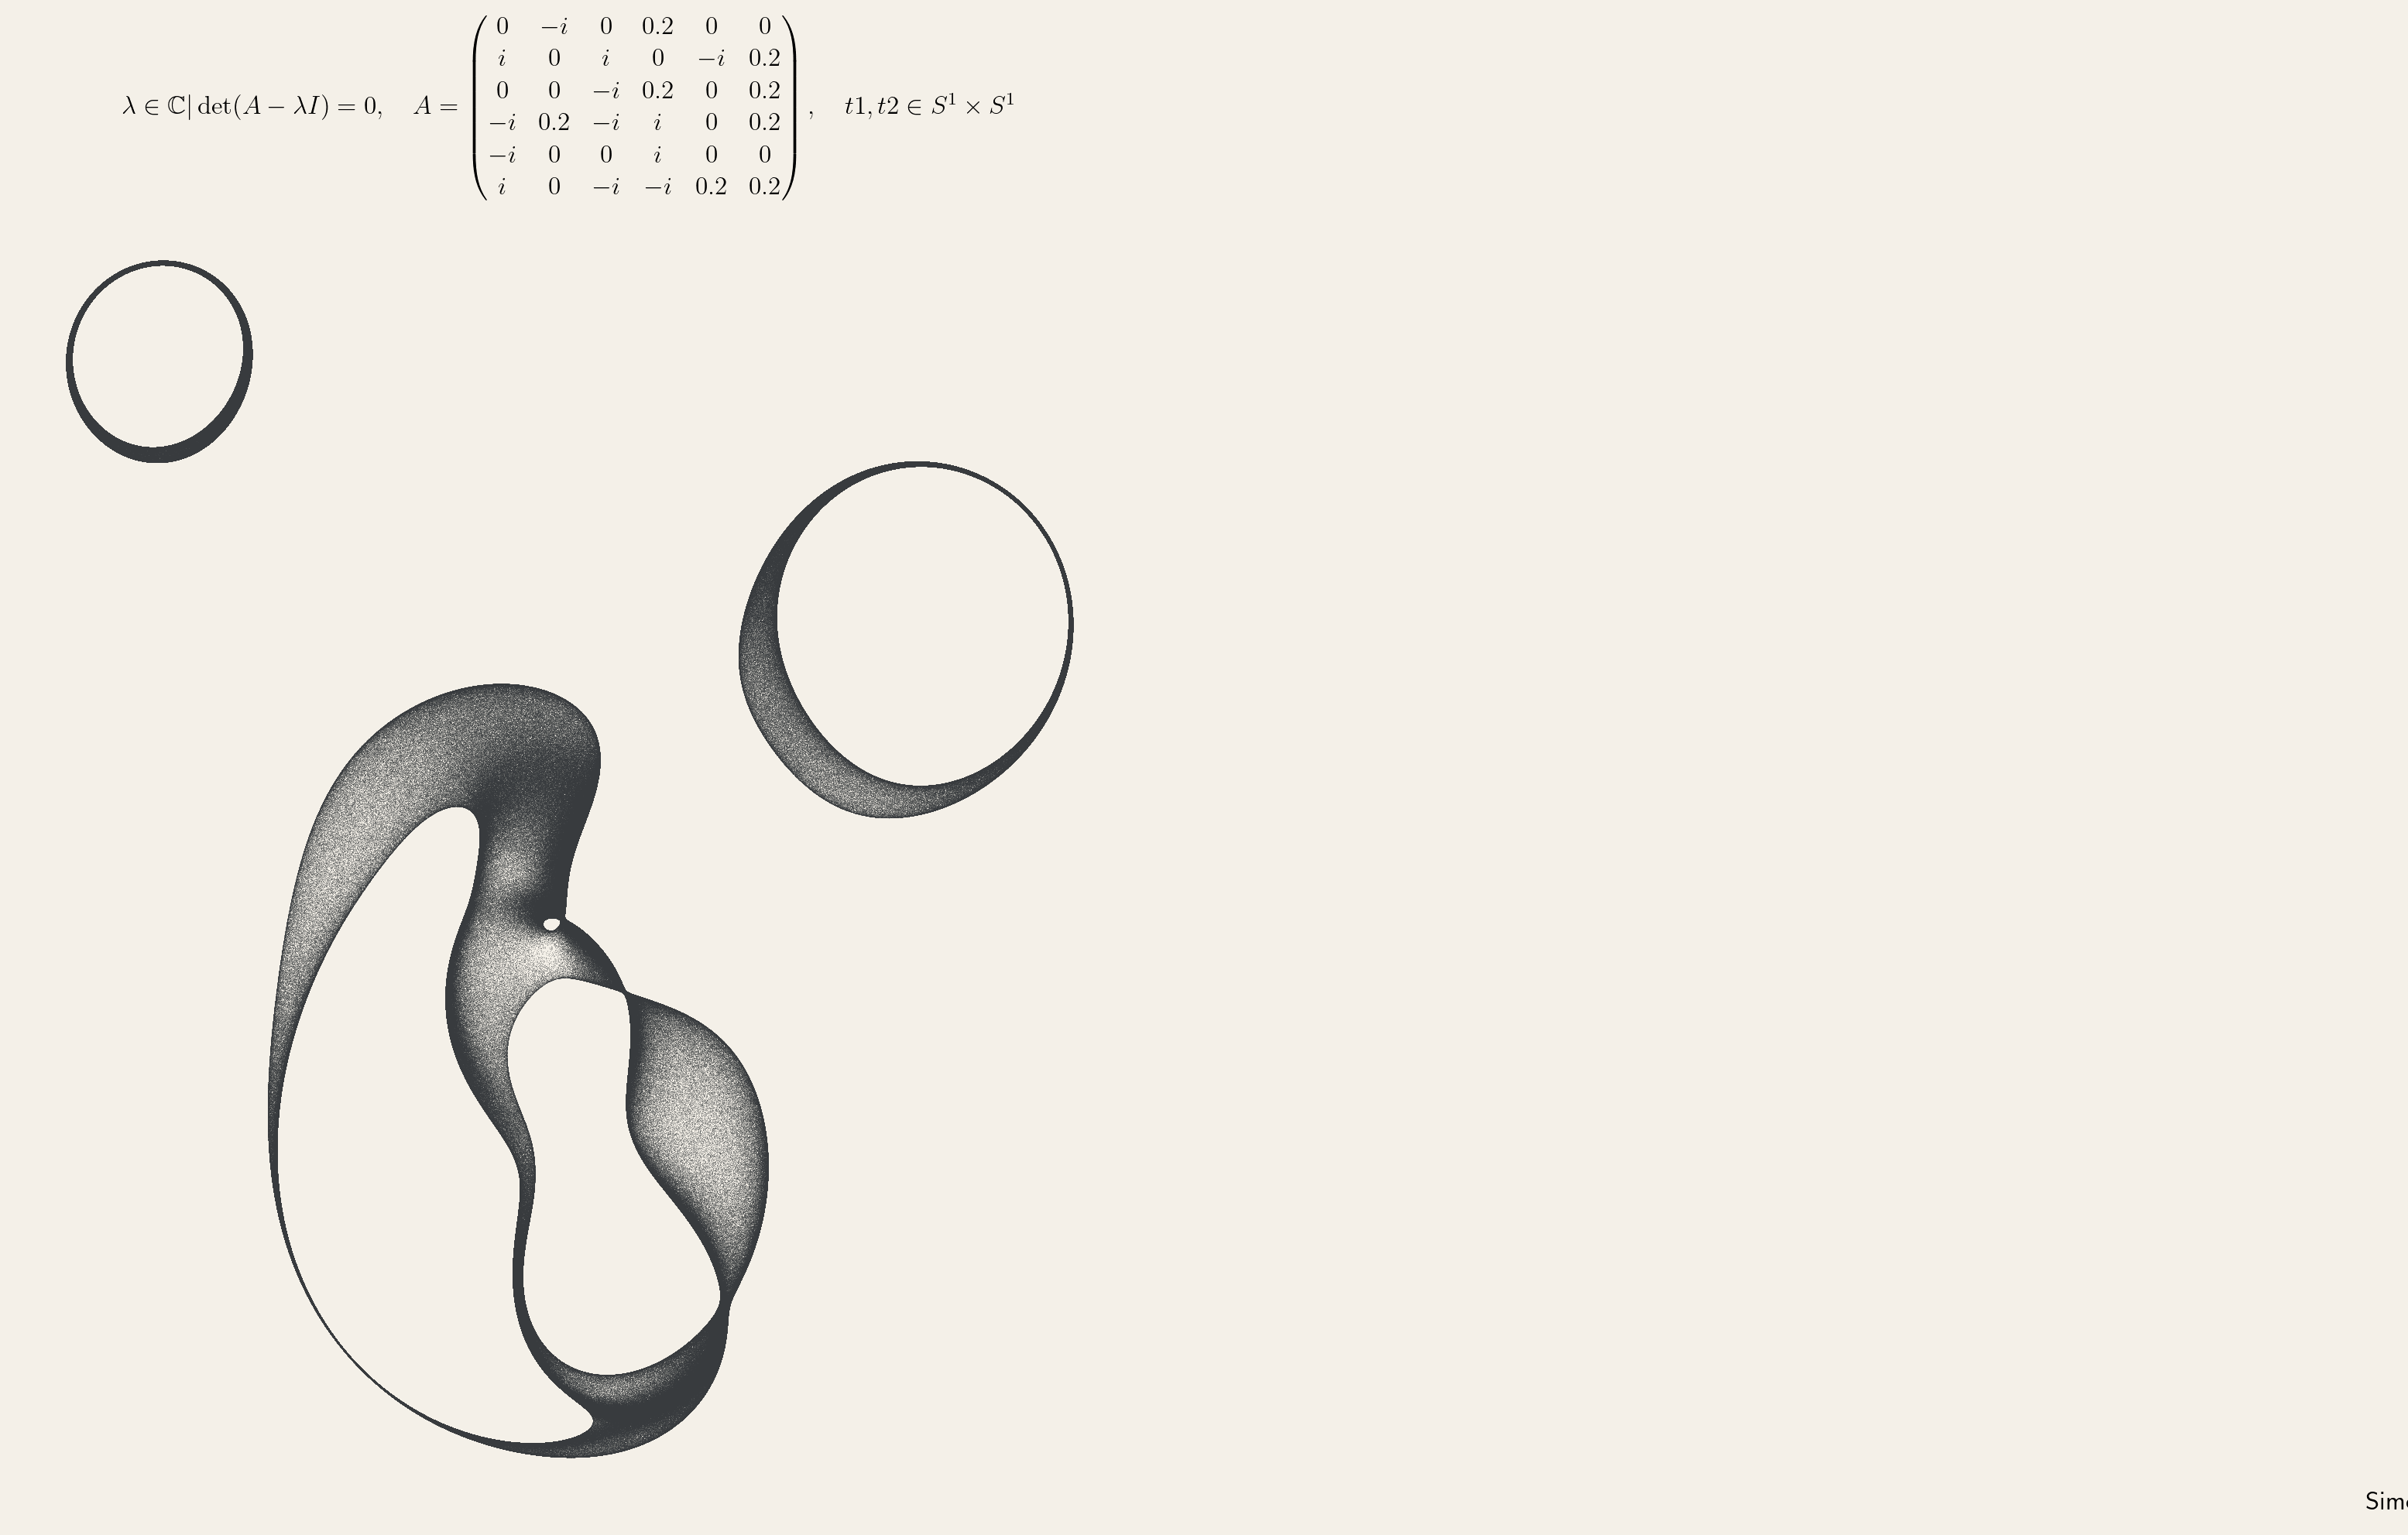

In [6]:
n_matrix = 500000
eigenfish = list_of_figure[0]

fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor("#f4f0e8")
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
for spine in ['top', 'right','left','bottom']:
    ax.spines[spine].set_visible(False)

eigenvalues = eigenfish.eigvals_random_ts_torus(n_matrix)
ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), c="#383b3e", s=0.05, linewidths= 0.0001, alpha=1.)

ax.set_title(eigenfish.create_latex_title_torus(), fontsize=12)
ax.set_aspect('equal', 'box')
#ax.set_xlim([-8,8])
#ax.set_ylim([-8,8])
ax.set_axis_off()
plt.tight_layout()
plt.annotate("Simone Conradi, 2023", (1100.,12.), xycoords="figure points", fontsize=12)
plt.show()    

### Creating a video
Use ffmpeg or Quicktime to build the video

In [7]:
mdim = 6
n_frames = 100
n_initial_frames = 10
sym_p_values = np.zeros(n_frames)
sym_p_values[n_initial_frames:] = np.linspace(0., 2., n_frames-n_initial_frames)
matrix = np.array([[-1.j,0,0,0,0,0],[0,0,1,1,0,1],[1.j,0,0,1,0,1.j],
                   [0,0,0,-1.j,-1.j,1.j],[-1.j,1,0,0,-1.j,1],[-1.j,1,0,0,0,-1.j]])
var_indices =(np.array([0, 0]), np.array([2, 5]))
eigenfish = Eigenfish(matrix, var_indices)

In [ ]:
n_matrix = 100000
for i in range(0,n_frames):
    out_path = "./image" + str(i).zfill(4) + ".png"

    fig, ax = plt.subplots(figsize=(4,4))
    fig.set_facecolor("#f4f0e8")
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    for spine in ['top', 'right','left','bottom']:
        ax.spines[spine].set_visible(False)
    sym_p = sym_p_values[i]
    matrix = np.array([[-1.j,0,0,0,0,0],[0,0,sym_p,sym_p,0,sym_p],[1.j,0,0,sym_p,0,1.j],
                   [0,0,0,-1.j,-1.j,1.j],[-1.j,sym_p,0,0,-1.j,sym_p],[-1.j,sym_p,0,0,0,-1.j]])
    var_indices =(np.array([0, 0]), np.array([2, 5]))
    eigenfish = Eigenfish(matrix, var_indices)
    eigenvalues = eigenfish.eigvals_random_ts_torus(n_matrix)
    ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), c="#383b3e", s=0.05, linewidths= 0.0001, alpha=1.)

    #ax.set_title(eigenfish.create_latex_title_torus(), fontsize=12)
    ax.set_title('$ \\{ \\lambda \\in \\mathbb{C} |  \\det(A-\\lambda I)=0, \\quad A=\\left( \\begin{array}{cccccc}-i & 0&  t_{1}  & 0& 0&  t_{2}  \\\\0& 0& x& x& 0& x\\\\i & 0& 0& x& 0& i \\\\0& 0& 0& -i & -i & i\\\\-i & x& 0& 0& -i & x\\\\-i & x& 0& 0& 0& -i \\end{array} \\right) , \\quad t_1,t_2\\in S^{1} \\times S^{1}  \\}$', fontsize=7)
    ax.set_aspect('equal', 'box')
    ax.set_xlim([-2.208098042011261, 2.3700588822364805])
    ax.set_ylim([-2.9683619290590286, 0.9622942358255386])
    ax.set_axis_off()
    plt.tight_layout()
    plt.annotate("Simone Conradi, 2023", (250.,5.), xycoords="figure points", fontsize=5)
    plt.annotate(r"$x = %s$"%str(np.round(sym_p, 2)), (20.,5.), xycoords="figure points", fontsize=12)
    plt.savefig(out_path, bbox_inches="tight", dpi=300)  
    plt.close()